Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Motivation:** To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion


### Importing all the important libraries

In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical # convert to one-hot-encoding

In [23]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [24]:
# Defining the path for train and test images
root_path = r'/content/gdrive/My Drive/skin_data_sets'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [25]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [26]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [27]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [28]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [29]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

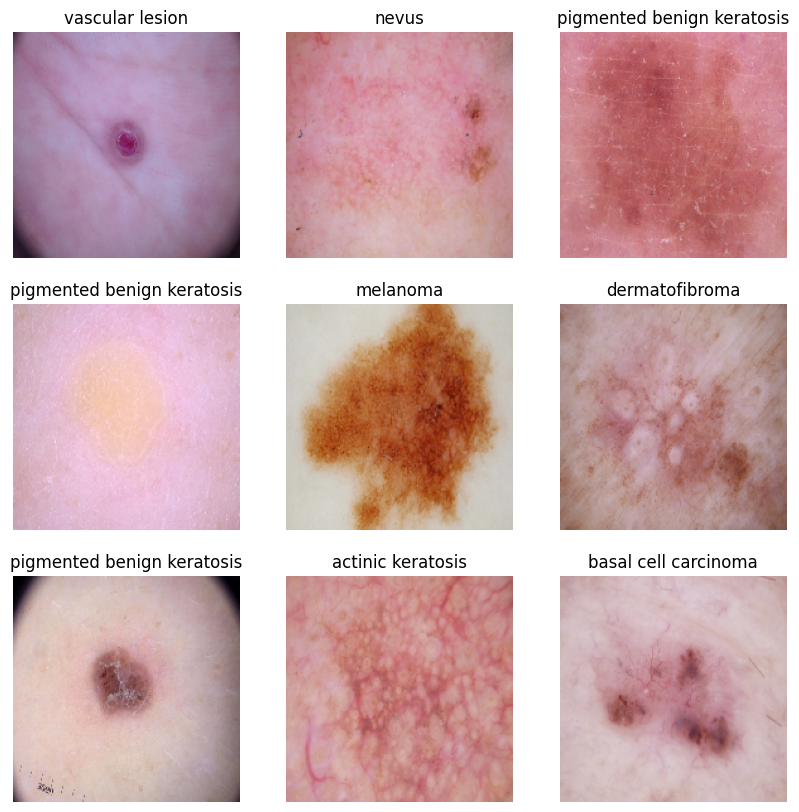

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [32]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 86, 86, 64)        256       
 chNormalization)                                     

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [33]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn='binary_crossentropy'

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 86, 86, 64)        256       
 chNormalization)                                     

### Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 353s 2s/step - loss: -69686.8516 - accuracy: 0.1713 - val_loss: -71163.1562 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: -837094.5000 - accuracy: 0.1724 - val_loss: -905245.5000 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: -3162541.7500 - accuracy: 0.1724 - val_loss: -3355621.7500 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: -7743734.5000 - accuracy: 0.1724 - val_loss: -7630903.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: -15383417.0000 - accuracy: 0.1724 - val_loss: -16921950.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: -26948146.0000 - accuracy: 0.1724 - val_loss: -22179632.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss:

### Visualizing training results

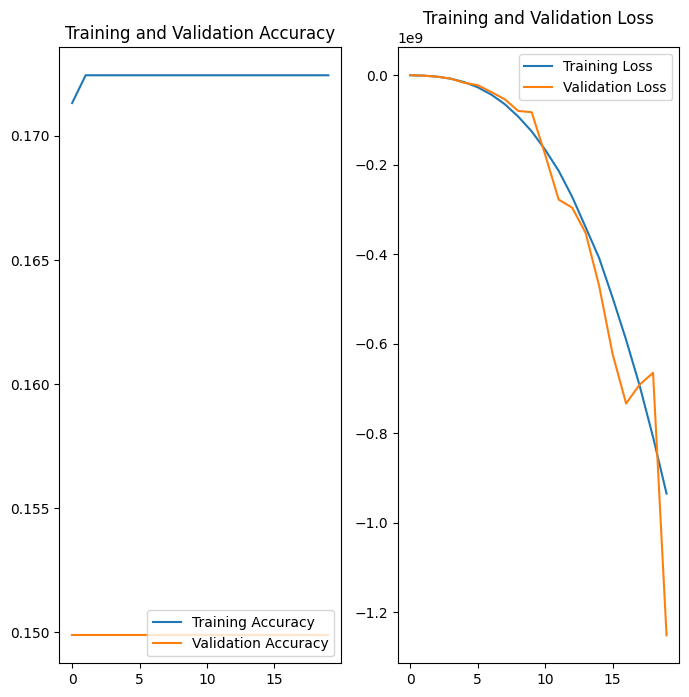

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Write your findings here
### Model Overfit or Underfit?


In [37]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 16ms/step - loss: -1252013824.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1222505728.0
Validation Loss -1252013824.0


In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


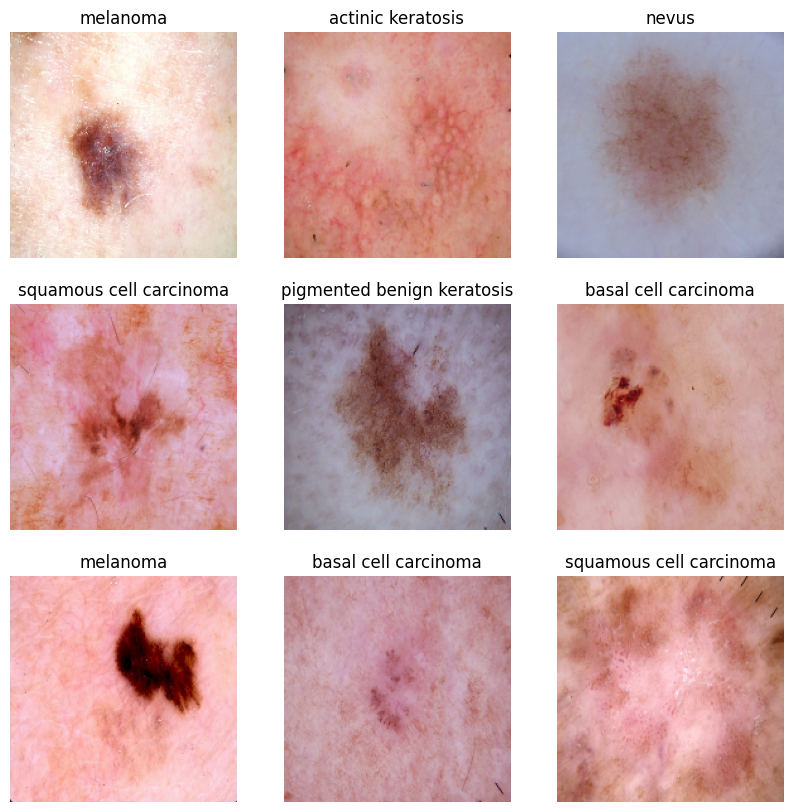

In [39]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

### Compiling the model

In [41]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, weight_decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

To help the optimizer converge faster and reach the global minimum, I used an annealing method for the learning rate (LR).

A higher LR leads to faster convergence with larger steps, but it risks poor sampling and getting stuck in local minima.

In [42]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Training the model

In [43]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches, epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 65s 4s/step - loss: 101.3529 - accuracy: 0.3652 - val_loss: 1.3858 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 24s 2s/step - loss: 1.0796 - accuracy: 0.4348 - val_loss: 1.5470 - val_accuracy: 0.2708 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 24s 2s/step - loss: 0.9889 - accuracy: 0.5101 - val_loss: 1.6617 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.9246 - accuracy: 0.5697
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 24s 2s/step - loss: 0.9246 - accuracy: 0.5697 - val_loss: 1.7051 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 23s 2s/step - loss: 0.8907 - accuracy: 0.5787 - val_loss: 1.6071 - val_accuracy: 0.4167 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 24s 2s/step - loss

### Visualizing the results

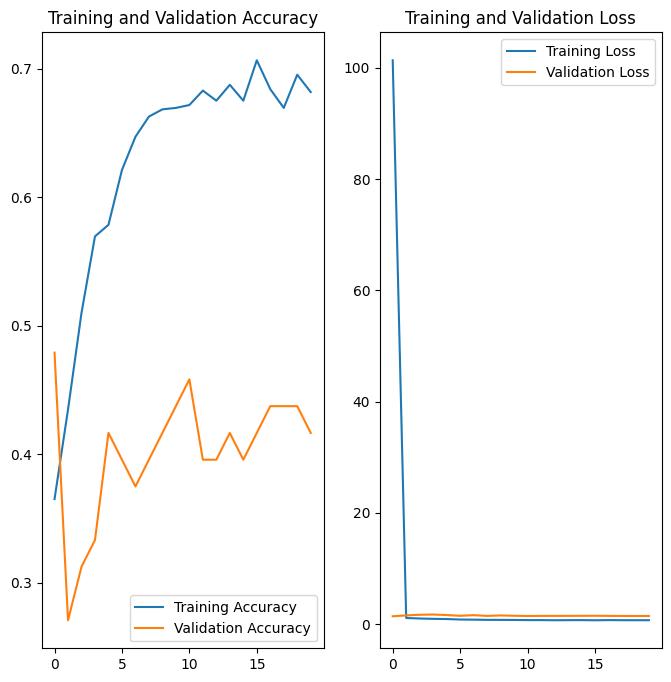

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
loss, accuracy = model.evaluate(train_batches, verbose=1,)
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

1/1 [==============================] - 3s 3s/step - loss: 1.4347 - accuracy: 0.4167
Accuracy:  0.7044943571090698
Validation Accuracy:  0.4166666567325592
Loss:  0.7826598286628723
Validation Loss 1.434697151184082



##### This model shows a substantial improvement over the first model. It has a moderate accuracy on the training data and a lower, yet reasonable, accuracy on the validation data. The positive loss values suggest the loss function is implemented correctly, but the gap between training and validation performance indicates overfitting

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

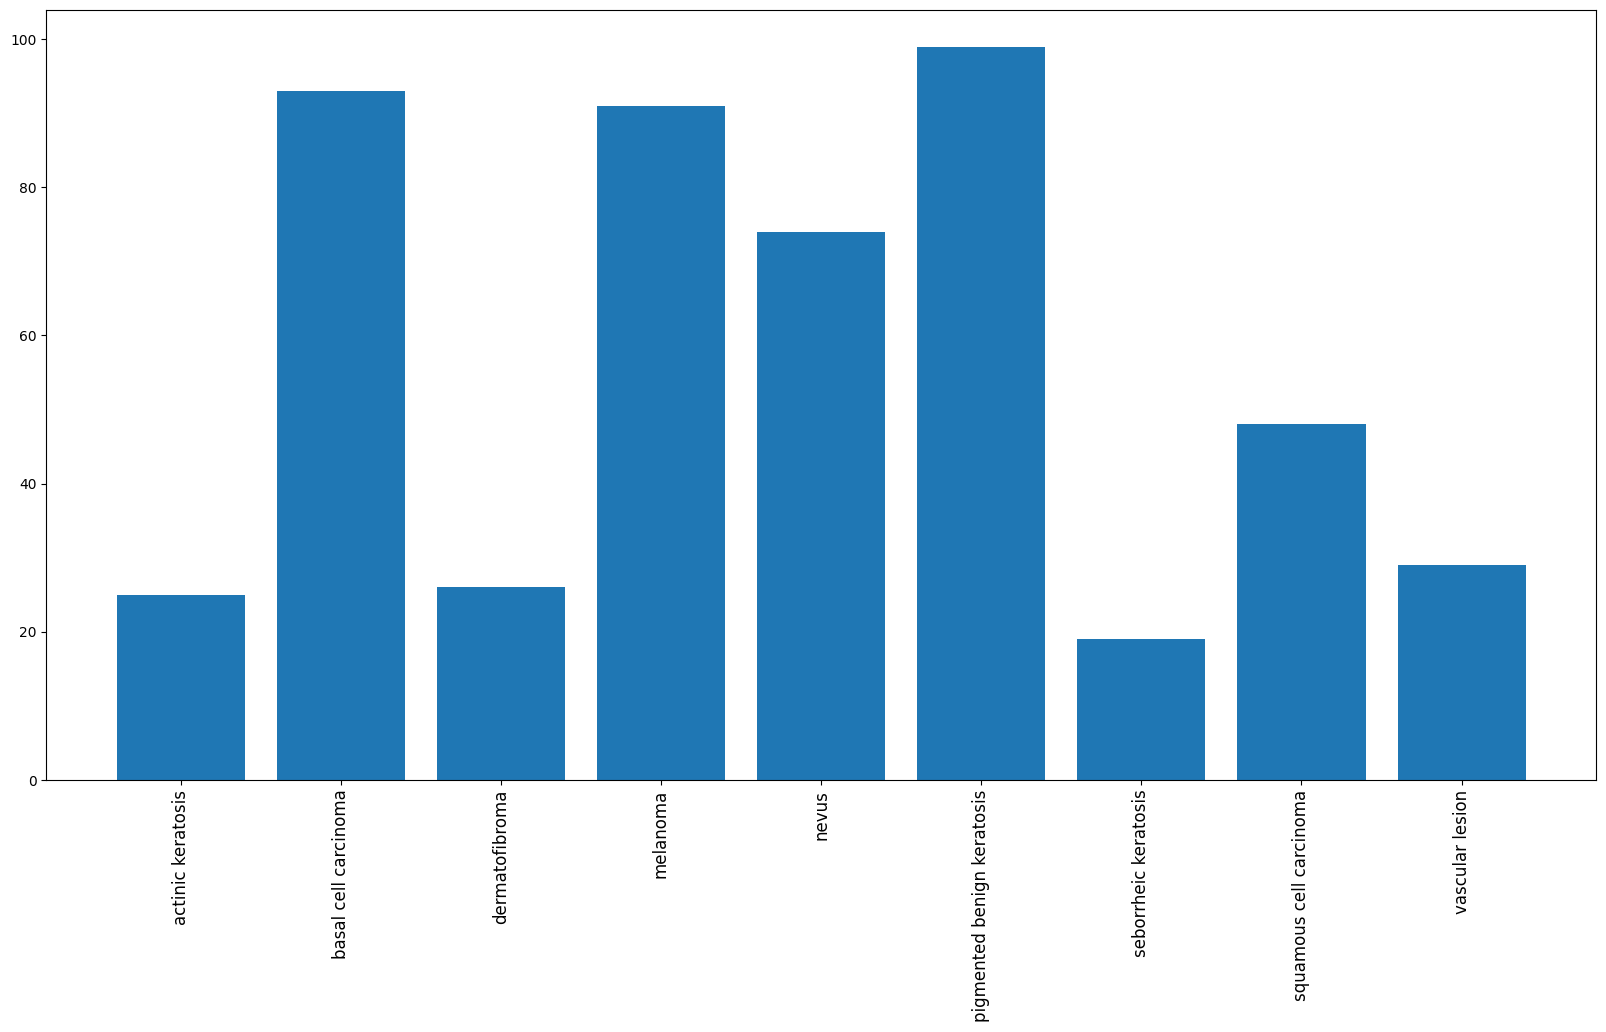

In [46]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(20, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()), rotation=90, fontsize=12, ha='center')
# plt.xticks()
plt.show()

#### - Which class has the least number of samples?
- seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis

#### **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [47]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [48]:
# root_path = r'/content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets'
# data_dir_train = pathlib.Path(root_path + '/Train')
path_to_training_dataset=r'/content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B0F357B50>: 100%|██████████| 500/500 [00:23<00:00, 21.03 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B3664EFB0>: 100%|██████████| 500/500 [00:24<00:00, 20.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6B0F4A8370>: 100%|██████████| 500/500 [00:18<00:00, 27.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E6B367B1F60>: 100%|██████████| 500/500 [01:36<00:00,  5.21 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7E6B0F4121D0>: 100%|██████████| 500/500 [01:15<00:00,  6.59 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B362295A0>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E6B366F25F0>: 100%|██████████| 500/500 [00:39<00:00, 12.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B362A0EB0>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6B362295D0>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [50]:
image_count_train_wo_op = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train_wo_op)

2239


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list


['/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0025046.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024550.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024564.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024787.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0025617.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0025301.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0025711.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024572.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024848.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0025299.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/ISIC_0024799.jpg',
 '/content/gdrive/My Drive/skin_

In [52]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030511.jpg_5f5ccd9b-b023-48d9-80c8-e37cf4c8e516.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027788.jpg_c02ba1b4-0ec9-4919-98aa-847eb2c7513f.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024665.jpg_ec8c7434-eb7a-4f4b-bd6e-388bc57643e6.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026668.jpg_d5eb37d3-8d96-41f1-a318-f91967cfd3a3.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029220.jpg_ad3798ea-f258-428d-a62e-6d58fb374b12.jpg',
 '/content/gdrive/My Drive/skin_data_sets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026528.jpg_eec70711-1809-4ced-8c39-96c1c3e1eb5a.jpg',
 '/c

In [63]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',


In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [65]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [66]:
original_df= pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
# new_df=df2

In [56]:
new_df['Label'].value_counts()

Label
basal cell carcinoma          500
pigmented benign keratosis    500
melanoma                      500
seborrheic keratosis          500
vascular lesion               239
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [58]:
data_dir_train=r'/content/gdrive/My Drive/my_upgrad/CNN/skin_data_sets/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [60]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [62]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, weight_decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [64]:
epochs = 30
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])




Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 59s 290ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 46s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 46s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1337
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 48s 273ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 46s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1337 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-04
Epoch 6/30
1

#### **Todo:**  Visualize the model results

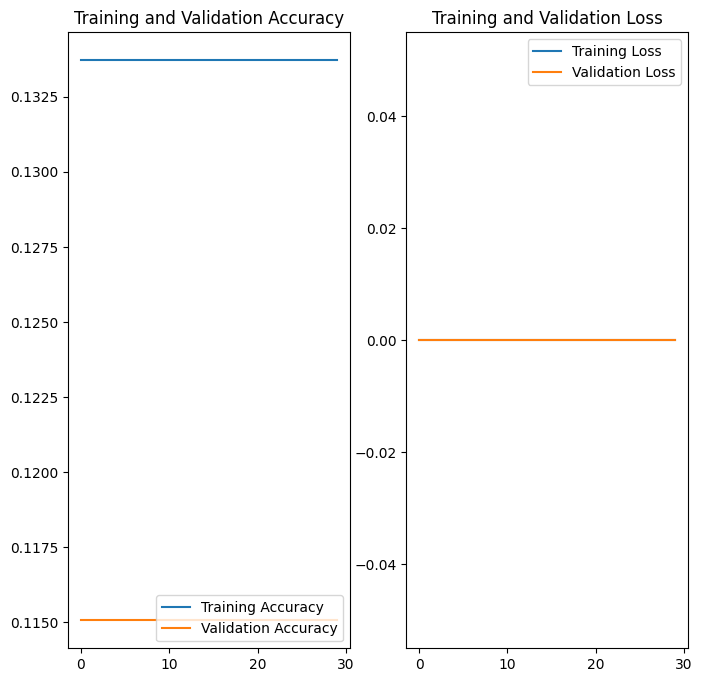

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### The class rebalancing helped reduce overfitting and lowered the loss, but it significantly decreased the accuracy. Initially, without using ImageDataGenerator, the model overfit to a high degree.Next, we introduced dropout and ImageDataGenerator, which helped mitigate overfitting.Finally, we implemented batch normalization and augmentation, which provided a substantial improvement.